In [105]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn
import helper

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Clustering

In this notebook, we will try to clusterize the players into 2 groups by choosing differents features
    
1. Aggregation
    * The data are displayed by dyad of referees, we need to group them by player
2. Cleaning
    * Prepare data for clusterization (e.g. strings mapped to integer values)
3. Clusterization
    * Use k-means algorithm with 2 cluster and test score with different feature selections
    * Improve on silhouette_score
    * Improve on accuracy (clusterization by skin colour)
4. Conclusion

## 2.1 Aggregation



In [84]:
# load data
df = pd.read_csv('./data/CrowdstormingDataJuly1st.csv')
print("shape : ", df.shape)
df.head(3)

shape :  (146028, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


### Is `playerShort` a unique key ??

As `playerShort` does not have a clear name defining it as a unique key for player, we want to ensure that it is the case. 

To do so, we will aggregate the `playerShort` with the birthday and check how many occurencies we have. If it is not a unique key, indeed, we will see a difference between number of `playerShort` and number of `playerShort`-`birthday`


In [78]:
print("number of unique playerShort: ", df['playerShort'].unique().shape[0])
print("number of unique playerShort and birthday: ", df.groupby(['playerShort', 'birthday']).size().count())

number of unique playerShort:  2053
number of unique playerShort and birthday:  2053


The `playerShort`field is, indeed, a unique ID for players.

We can see below that it deals with players having the same name by adding an extra number, which make `playerShort` a unique key.

In [79]:
df.loc[df["playerShort"].str.contains("abdoulaye-diallo")]['playerShort'].unique()

array(['abdoulaye-diallo_2', 'abdoulaye-diallo_3'], dtype=object)

### Remove columns impossible to aggregate
* useless column
    * photoID
* impossible to aggregate
    * refNum
    * refCountry
    * Alpha_3
    * meanIAT
    * nIAT
    * seIAT
    * meanExp
    * nExp
    * seExp

In [1]:
# really useless column
col_to_remove = ['photoID']
col_to_remove += ['player']
# columns impossible to aggregate, because represent information on referee
col_to_remove += ['refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']
# name is already contained in playerShort
df_clean = df.drop(col_to_remove, axis=1)
print("shape : ", df_clean.shape)

NameError: name 'df' is not defined

### Aggregation on `playerShort`

In order to aggregate value, we follow two different rules:
* **Keeping only one value** (the first): 
    * typically for values the we suppose to be unique for each player (height, birthday) 
    * or values too hard to be aggregated in other ways (club, ...)
* **Summing the values**: 
    * typically for integer values (victories, cards, ...)

In [83]:
# function that keeps only the first value
sole_value = lambda x : list(x)[0]

#dictionary that maps columns to aggregation functions
agg_funcs = {'club' : sole_value, 'leagueCountry' : sole_value, 'birthday' : sole_value, \
             'height' : sole_value,'weight' : sole_value,'position' : sole_value, \
             'rater1' : sole_value, 'rater2' : sole_value, \
            'games' : sum, 'victories' : sum, 'ties' : sum, \
            'defeats' : sum, 'goals' : sum, 'yellowCards' : sum, \
             'yellowReds' : sum, 'redCards' : sum}

#group and aggregate
df_player = df_clean.groupby('playerShort', as_index = True).agg(agg_funcs)
print("shape: ", df_player.shape)
df_player.head(3)

shape:  (2053, 16)


,defeats,weight,rater2,games,redCards,height,victories,yellowReds,rater1,leagueCountry,goals,club,yellowCards,ties,position,birthday
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,228,71.0,0.00,654,0,182.0,247,0,0.25,England,9,Fulham FC,19,179,Center Back,08.11.1979
aaron-hunt,122,73.0,0.25,336,1,183.0,141,0,0.00,Germany,62,Werder Bremen,42,73,Attacking Midfielder,04.09.1986
aaron-lennon,115,63.0,0.25,412,0,165.0,200,0,0.25,England,31,Tottenham Hotspur,11,97,Right Midfielder,16.04.1987


### Computing a `skin_colour` feature

Obtained by the mean of `rater1` and `rater2` features (which will be removed then, as they are no more useful)

In [87]:
# deep copy
df_player_color = pd.DataFrame.copy(df_player)

# 1 dark skin; 0 white skin
df_player_color['skin_colour'] = df_player_color[['rater1', 'rater2']].mean(axis=1) > 0.5
df_player_color['skin_colour'] = df_player_color['skin_colour'].astype(int)

# remove rater1 and rater2
df_player_color = df_player_color.drop(['rater1', 'rater2'], axis=1)

print("shape: ", df_player_color.shape)
df_player_color.head(2)

shape:  (2053, 15)


,defeats,weight,games,redCards,height,victories,yellowReds,leagueCountry,goals,club,yellowCards,ties,position,birthday,skin_colour
playerShort,,,,,,,,,,,,,,,
aaron-hughes,228,71.0,654,0,182.0,247,0,England,9,Fulham FC,19,179,Center Back,08.11.1979,0
aaron-hunt,122,73.0,336,1,183.0,141,0,Germany,62,Werder Bremen,42,73,Attacking Midfielder,04.09.1986,0


In [97]:
df_player_color.isnull()

,defeats,weight,games,redCards,height,victories,yellowReds,leagueCountry,goals,club,yellowCards,ties,position,birthday,skin_colour
playerShort,,,,,,,,,,,,,,,
aaron-hughes,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
aaron-hunt,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
aaron-lennon,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
aaron-ramsey,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
abdelhamid-el-kaoutari,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
abdon-prats,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
abdou-dampha,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
abdou-traore_2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
abdoul-camara,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## 2. Cleaning : Preparing data for clustering

We need to work on numerical values only. To deal with it we follow the rules:

* Give an ID to string values:
    * club
    * leagueCountry
    * position
* Replace float by int:
    * height
    * weight
* Only keep year of the whole date:
    * birthday
* Reindex
* Remove `playerShort`


In [100]:
def clean_df(df):    
    def keep_year(df):
        df['birthday'] = df['birthday'].astype(str).str[6 :].astype(np.int16)

    def replace_nan_by_mean(df, field):
        df[field] = df[field].fillna((df[field].mean()), inplace = False)

    def replace_to_id(df, fields):
        for field in fields:
            df[field] = df[field].astype('category').cat.codes
            
    def replace_to_int(df, fields):
        for field in fields:
            df[field] = df[field].astype(int)

    # deep copy of DataFrame and reindexing
    df_clean = pd.DataFrame.copy(df)
    df_clean = df_clean.reset_index()
    
    # deal with NaN
    replace_nan_by_mean(df_clean, 'height')
    replace_nan_by_mean(df_clean, 'weight')

    # format data to be processable by classifier (only integers)
    replace_to_id(df_clean, ['club', 'leagueCountry', 'position'])
    replace_to_int(df_clean, ['height', 'weight'])
    keep_year(df_clean)

    # drop 
    df_clean = df_clean.drop('playerShort', axis=1)
    df_clean['skin_colour'] = df_clean['skin_colour'].astype(int)
    return df_clean

df_player_to_id = clean_df(df_player_color)
df_player_to_id.head(5)

,defeats,weight,games,redCards,height,victories,yellowReds,leagueCountry,goals,club,yellowCards,ties,position,birthday,skin_colour
0,228,71,654,0,182,247,0,0,9,42,19,179,1,1979,0
1,122,73,336,1,183,141,0,2,62,110,42,73,0,1986,0
2,115,63,412,0,165,200,0,0,31,100,11,97,10,1987,0
3,68,76,260,1,178,150,0,0,39,8,31,42,3,1990,0
4,43,73,124,2,180,41,4,1,1,62,8,40,1,1990,0


## 3. Clustering

We apply k-means algorithm from sklearn library

* **silhouette_kmeans**: process a k-means clustering and return silhouette_score and label_score
* **score_labels**: helper to compute label_score
* **remove_one_feature**: process k-means by droping each feature one time and compute the silhouette_score and label_score resulting of this deletion

In [103]:
def silhouette_kmeans(df):
    # drop label column
    X = df.drop('skin_colour', axis=1).as_matrix()
    
    # k-means
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    labels = kmeans.labels_
    
    # compute 
    silhouette =  sklearn.metrics.silhouette_score(X, labels, metric="euclidean")
    return silhouette, score_labels(df, labels)

def score_labels(df, labels):
    score = (labels == df['skin_colour']).sum()
    score = max(score, labels.size - score) / labels.size
    return score

def remove_one_feature(df):
    columns_names = list(df.columns.values)[:-1] # remove skin_colours from the iterable 
    dic_silouhette = {}
    dic_score = {}
    base_sil, base_score = silhouette_kmeans(df)
    for name in columns_names:
        sil, score = silhouette_kmeans(df.drop(name, axis = 1))
        dic_silouhette[name] = sil
        dic_score[name] = score
        
    return base_sil, base_score, dic_silouhette, dic_score

### One step feature removal

As an example, let's have a look at one feature deletion. The following graph give the achived silhouettes and scores by removing each of these features.

The dashed line give the silhouette and score of the k-means without removal to have a comparison point.

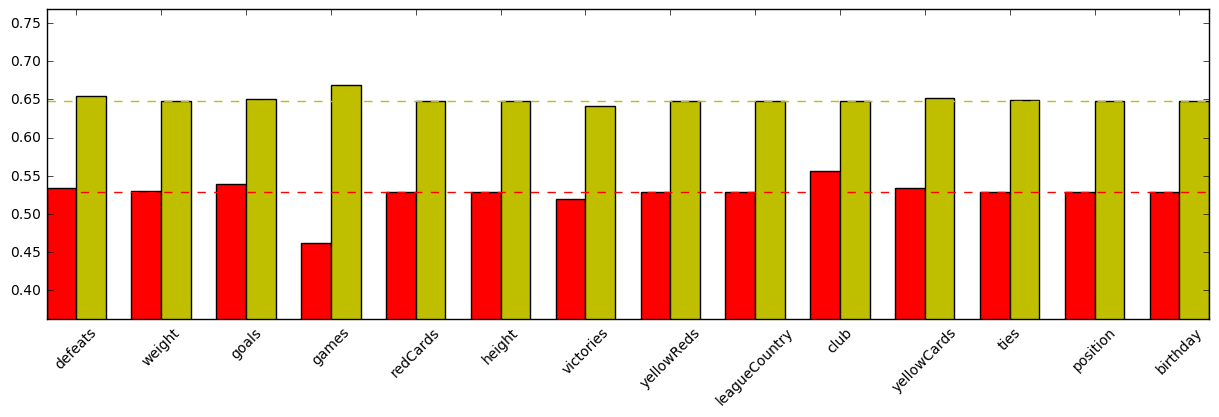

In [106]:
base_sil, base_score, dic_sil, dic_score = remove_one_feature(df_player_to_id)
fig = helper.plot_dict(dic_sil, dic_score, base_sil, base_score)

### Optimize silhouette and labell scores

In order to improve our algorithm, we will select one by one the best feature to remove and iterate.

Algorithm stop if we cannot improve more the our clusters or if it only remains one feature.

In [107]:
def optimize(base_sil, base_score, df, optimize_on):
    removed_columns = []
    removed_columns_sil = []
    removed_columns_score = []
    while True:
        base_sil, base_score, dic_sil, dic_score = remove_one_feature(df.drop(removed_columns, axis=1))
        
        if optimize_on == 'silhouette':
            feature_to_remove = max(dic_sil, key=lambda i: dic_sil[i])
            is_not_improving = dic_sil[feature_to_remove] <= base_sil
        else:
            feature_to_remove = max(dic_score, key=lambda i: dic_score[i])
            is_not_improving = dic_score[feature_to_remove] <= base_score
            
        # test if we are improving
        if is_not_improving:
            break
            
        removed_columns.append(feature_to_remove)
        removed_columns_sil.append(dic_sil[feature_to_remove])
        removed_columns_score.append(dic_score[feature_to_remove])
            
        # test if we are dropping the last feature
        if len(removed_columns) > df.columns.values.size-3:
            break
            
    return removed_columns, removed_columns_sil, removed_columns_score

Features removed iteratively and the corresponding silhouette and label score
red: silhouette, green: label_score
Remaining features:  {'leagueCountry'}
silhouette score:  0.733303869983
label score:  0.516804676084


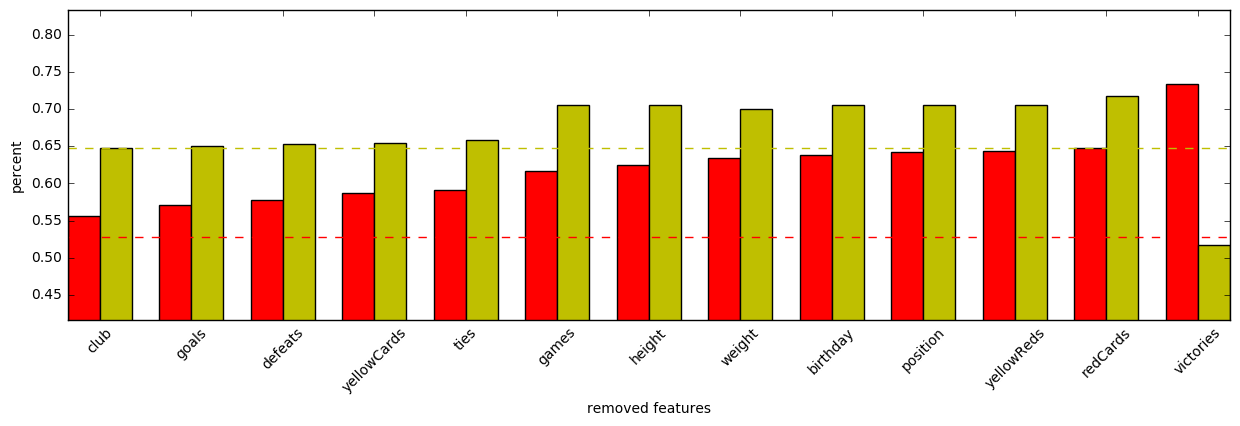

In [111]:
base_sil, base_score = silhouette_kmeans(df_player_to_id)
col, col_sil, col_score = optimize(base_sil, base_score, df_player_to_id, optimize_on='silhouette')
print("Features removed iteratively and the corresponding silhouette and label score")
print("red: silhouette, green: label_score")
print("Remaining features: ", set(df_player_to_id.columns.values[:-1]) -  set(col))
print("silhouette score: ", col_sil[-1])
print("label score: ", col_score[-1])
fig = helper.plot_array(col, col_sil, col_score, base_sil, base_score, labelx="removed features", labely="percent")

Features removed iteratively and the corresponding silhouette and label score
red: silhouette, green: label_score
Remaining features:  {'weight', 'position', 'height', 'redCards', 'yellowReds', 'leagueCountry', 'goals', 'club', 'birthday'}
silhouette score:  0.551233683583
label score:  0.818801753531


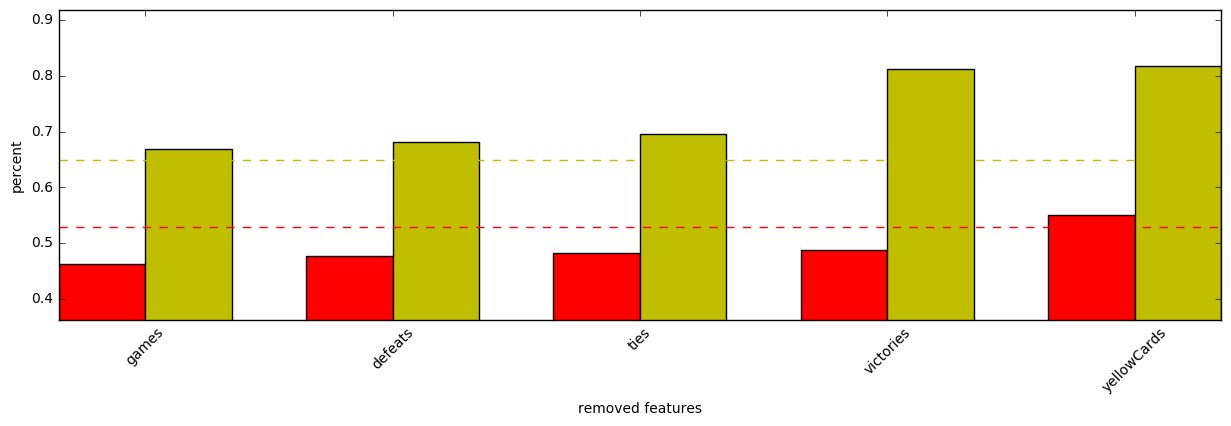

In [112]:
base_sil, base_score = silhouette_kmeans(df_player_to_id)
col, col_sil, col_score = optimize(base_sil, base_score, df_player_to_id, optimize_on='score')
print("Features removed iteratively and the corresponding silhouette and label score")
print("red: silhouette, green: label_score")
print("Remaining features: ", set(df_player_to_id.columns.values[:-1]) -  set(col))
print("silhouette score: ", col_sil[-1])
print("label score: ", col_score[-1])
fig = helper.plot_array(col, col_sil, col_score, base_sil, base_score, labelx="removed features", labely="percent")

## 4. Conclusion

### Optimizing on silhouette
Optimizing on silhouette and keeping only `leagueCountry` allows to achieve a silhouette score of 0.73. However, this doesn't make any sens as we can see comparing with the `label_score`.

Optimizing on silhouette and keeping `leagueCountry` and `victories` allows to achieve a silhouette score of ~0.65 with a high label score of ~0.72. This is, in our opinion, the best solution.

### Optimizing on label score
This optimization does not make really sens, as it is a kind of overfitting. Anyway, we did it to see it's result and confirm our suspicion. We can achieve a score of ~0.81 but a very low silhouette, which means that the data are not well clusterized.

### Is there any correlations between skin colours and referee intervention ???
The study of these data leads us to actually ask ourselves **if there is any correlaction** or if we are just trying to reveal something that doesn't exist. Anyway, just looking at the available data, it is hard to drow any conclusion about racism in football, and, as **any case of doubt shall be resolved in favour of the accused**, we will say that their is no evidence of racisme.

On the opposite, the best way to clustierize the data is on `victories`. I let you drow the conclusion yourself =P